In [1]:
from gurobipy import *

In [2]:
def IPS6(ship_num,stack_num,height,n,size,beta):
  S=[i+1 for i in range(stack_num)]
  H=[i+1 for i in range(height)]
  P=[i+1 for i in range(ship_num)]
  f=stack_num*height-sum(n)

  from asyncio.constants import SENDFILE_FALLBACK_READBUFFER_SIZE
  import random
  from random import seed
  import numpy as np
  from scipy.stats import multivariate_normal

  # 期待値と分散共分散行列の準備
  random.seed(1)
  np.random.seed(0)
  a=np.arange(1,2*ship_num,0.4)
  a=list(a)
  a=random.sample(a,ship_num)
  mean=np.sort(a)
  cov=np.zeros((ship_num,ship_num))
  for i in range(ship_num):
      for j in range(ship_num):
          if i==j:
              cov[i][i]=2*abs(np.random.randn())
  for i in range(ship_num):
      for j in range(ship_num):
          if i!=j:
              cov[i][j]=(-0.75)**abs(i-j)
  np.random.seed()
  data_1 = np.random.multivariate_normal(mean, cov, size=size)

  O_=np.argsort(data_1)
  O_=O_+np.ones((size,ship_num)).astype(int)
  O=O_.tolist()
  # a=[]
  # b={}
  # for i in O:
  #   # print(i)
  #   if not i in a:
  #     a.append(i)
  #     for j in a:
  #       b[tuple(j)]=O.count(j)

  m=Model("IPS6")

  alpha=m.addVar(vtype="C")

  # 変数の定義
  x,c,d={},{},{}
  for s in S:
    for h in H:
      for p in P:
        x[s,h,p]=m.addVar(vtype="B")

  for s in S:
    for h in range(2,len(H)+1):
      for i,o in enumerate(O):
        c[s,h,i]=m.addVar(vtype="c",lb=0)

  for i in range(len(O)):
    d[i]=m.addVar(vtype="C",lb=0)

  for p in P:
    m.addConstr(quicksum(x[s,h,p] for s in S for h in H)==n[p-1])

  for s in S:
    for h in H:
      m.addConstr(quicksum(x[s,h,p] for p in P)<=1)

  for s in S:
    for h in range(1,len(H)):
      m.addConstr(quicksum(x[s,h+1,p] for p in P)<=quicksum(x[s,h,p] for p in P))

  for s in S:
    for h in range(2,len(H)+1):
      for h_ in range(1,h):
        for i,o in enumerate(O):
          for j,p in enumerate(o):
            m.addConstr(c[s,h,i]>=quicksum(x[s,h,k] for k in o[j:])-quicksum(x[s,h_,k] for k in o[j:]))

  for i in range(len(O)):
    m.addConstr(d[i]>=quicksum(c[s,h,i] for s in S for h in H if h!=1)-alpha)


  m.setObjective(alpha+quicksum(d[i] for i in range(len(O)))/((1-beta)*len(O)))

  if f>=height:
    m.optimize()
  else:
    print("f<h")

  print("================================================")

  EPS=1.e-6

  if m.Status == GRB.OPTIMAL:
    global result
    result=np.zeros((height,stack_num))
    for (s,h,p) in x:
      if x[s,h,p].X>EPS:
        result[height-h][s-1]=int(p)

    result=result.astype(int)
    print("VaR=",alpha.X)
    print("the objective function", m.objVal)
    print(result)

    np.random.seed()
    data_2 = np.random.multivariate_normal(mean, cov, size=size)

    global OR
    OR_=np.argsort(data_2)
    OR_=OR_+np.ones((size,ship_num)).astype(int)
    OR=OR_.tolist()

    global penalty
    penalty=[]
    for k in OR:
      O=k
      a=0
      for j in range(stack_num):
          for i in range(1,height):
              for i_ in range(i+1,height+1):
                  if result[i-1][j]!=0 and result[i_-1][j]!=0:
                      if O.index(result[i-1][j])>O.index(result[i_-1][j]):
                          print(j+1,height-i+1,O)
                          a+=1
                          break
      penalty.append(a)
    penalty=np.sort(penalty)
    penalty=penalty[round(0.95*size):]

In [10]:
inst=[[5,5,[3,2,2,2,1,2,2,2,1,3]],[6,4,[3,2,2,2,1,2,2,2,1,3]],[4,4,[2,3,3,1,3]],[6,6,[2,3,1,3,2,3,2,4,3,2]],[6,6,[3,4,2,2,3,2,1,2,1,2,3,2]],[6,4,[2,2,3,2,4,2]]]
pcvar=[]
for i in inst:
  ship_num=len(i[2])
  size=1000
  IPS6(ship_num,i[0],i[1],i[2],size,0.7)
  pcvar+=list(penalty)

C:\Users\Owner\AppData\Local\Temp\ipykernel_5552\4119912885.py:30: RuntimeWarning: covariance is not positive-semidefinite.
  data_1 = np.random.multivariate_normal(mean, cov, size=size)


Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 501055 rows, 21251 columns and 6022900 nonzeros
Model fingerprint: 0x411846f4
Variable types: 21001 continuous, 250 integer (250 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 3540 rows and 0 columns (presolve time = 5s) ...
Presolve removed 3540 rows and 0 columns (presolve time = 10s) ...
Presolve removed 284994 rows and 11844 columns
Presolve time: 14.85s
Presolved: 216061 rows, 9407 columns, 2617582 nonzeros
Variable types: 9157 continuous, 250 integer (250 binary)
Found heuristic solution: objective 12.2133333

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   2.738992e+05     17s
     429   -0.0000000e+00   0.000000

C:\Users\Owner\AppData\Local\Temp\ipykernel_5552\4119912885.py:109: RuntimeWarning: covariance is not positive-semidefinite.
  data_2 = np.random.multivariate_normal(mean, cov, size=size)


Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 361052 rows, 19241 columns and 4340840 nonzeros
Model fingerprint: 0x00df7df0
Variable types: 19001 continuous, 240 integer (240 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 2286 rows and 0 columns (presolve time = 5s) ...
Presolve removed 206831 rows and 10811 columns
Presolve time: 9.91s
Presolved: 154221 rows, 8430 columns, 1865692 nonzeros
Variable types: 8190 continuous, 240 integer (240 binary)
Found heuristic solution: objective 9.9333333

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                         11s
    1464   -0.0000000e+00   0.000000e+00   0.000000e+00     12s
    1464   -0.0000000e+00   0.000000e+00 

In [11]:
def robust(ship_num,stack_num,height,n,Gamma,size):
    # nと初期配置を変更しなければいけない
    num=sum(n)

    import numpy as np

    Q=[i+1 for i in range(stack_num)]
    L=[i+1 for i in range(height)]
    P=[i+1 for i in range(ship_num)]
    I=[i+1 for i in range(num)]
    f=stack_num*height-len(I)
    a=1
    gamma=[]
    for i in n:
        for j in range(1,i+1):
            gamma.append(a)
        a+=1
    
    m=Model("BI")

    # 変数の定義
    alpha,beta={},{}
    for i in I:
        for q in Q:
            alpha[i,q]=m.addVar(vtype="B")
            beta[i,q]=m.addVar(vtype="B")
    J=[]
    for i in I:
        J.append([])
        for j in I:
            if gamma[i-1]<gamma[j-1]:
                if gamma[j-1]-gamma[i-1]<=Gamma:
                    J[i-1].append(j)

    for q in Q:
        m.addConstr(quicksum((alpha[i,q]+beta[i,q]) for i in I)<=len(L))

    for i in I:
        m.addConstr(quicksum((alpha[i,q]+beta[i,q]) for q in Q)==1)

    for i in I:
        for j in J[i-1]:
            for q in Q:
                m.addConstr(alpha[i,q]+alpha[j,q]+beta[j,q]<=1)

    m.setObjective(quicksum(beta[i,q] for i in I for q in Q))

    if f>=height:
        m.optimize()

    EPS=1.e-6

    if m.Status == GRB.OPTIMAL:
        print("====================================================")
        EPS=1.e-6
        a=[]
        for q in Q:
            a.append([])
        for (i,q) in alpha:
            if alpha[i,q].X>EPS:
                a[q-1].append(gamma[i-1])
        
        for (i,q) in beta:
            if beta[i,q].X>EPS:
                a[q-1].append(gamma[i-1])

        for q in Q:
            a[q-1]=sorted(a[q-1],reverse=True)

        global result_r
        result_r=np.zeros((height,stack_num))
        for q in Q:
            for i,r in enumerate(a[q-1]):
                result_r[height-i-1][q-1]=r
            # print(i,r)

        result_r=result_r.astype(int)
        
        print(result_r)
        print("the objective function", m.objVal)

        from asyncio.constants import SENDFILE_FALLBACK_READBUFFER_SIZE
        import random
        from random import seed
        import numpy as np
        from scipy.stats import multivariate_normal
        random.seed(1)
        np.random.seed(0)
        # 期待値と分散共分散行列の準備
        a=np.arange(1,2*ship_num,0.4)
        a=list(a)
        a=random.sample(a,ship_num)
        mean=np.sort(a)
        cov=np.zeros((ship_num,ship_num))
        for i in range(ship_num):
            for j in range(ship_num):
                if i==j:
                    cov[i][i]=2*abs(np.random.randn())
        for i in range(ship_num):
            for j in range(ship_num):
                if i!=j:
                    cov[i][j]=(-0.75)**abs(i-j)
        np.random.seed()
        data_1 = np.random.multivariate_normal(mean, cov, size=size)

        O_=np.argsort(data_1)
        O_=O_+np.ones((size,ship_num)).astype(int)
        OR=O_.tolist()


        global penalty_r
        penalty_r=[]
        for k in OR:
            O=k
            a=0
            for j in range(stack_num):
                for i in range(1,height):
                    for i_ in range(i+1,height+1):
                        if result_r[i-1][j]!=0 and result_r[i_-1][j]!=0:
                            if O.index(result_r[i-1][j])>O.index(result_r[i_-1][j]):
                                print(j+1,height-i+1,O)
                                a+=1
                                break
            penalty_r.append(a)
        
        penalty_r=np.sort(penalty_r)
        penalty_r=penalty_r[round(0.95*size):]
        print(penalty_r)


Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 180 rows, 200 columns and 865 nonzeros
Model fingerprint: 0x8d18caaa
Variable types: 0 continuous, 200 integer (200 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 16.0000000
Presolve removed 0 rows and 15 columns
Presolve time: 0.00s
Presolved: 180 rows, 185 columns, 820 nonzeros
Found heuristic solution: objective 0.0000000
Variable types: 0 continuous, 185 integer (185 binary)

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 16 (of 16 available processors)

Solution count 2: 0 16 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
[[ 3  1  1  0  0]
 [ 3  1  4  0  0

C:\Users\Owner\AppData\Local\Temp\ipykernel_5552\3384373693.py:104: RuntimeWarning: covariance is not positive-semidefinite.
  data_1 = np.random.multivariate_normal(mean, cov, size=size)


 5 [4, 2, 1, 3, 5, 6, 8, 9, 7, 10]
1 5 [1, 2, 5, 3, 4, 6, 8, 7, 10, 9]
1 4 [1, 2, 5, 3, 4, 6, 8, 7, 10, 9]
3 4 [2, 1, 3, 6, 4, 5, 7, 8, 9, 10]
3 4 [1, 2, 3, 5, 6, 4, 7, 8, 9, 10]
3 5 [2, 4, 3, 5, 1, 7, 6, 9, 8, 10]
1 5 [2, 5, 1, 4, 3, 7, 9, 6, 8, 10]
1 4 [2, 5, 1, 4, 3, 7, 9, 6, 8, 10]
3 3 [2, 5, 1, 4, 3, 7, 9, 6, 8, 10]
3 2 [2, 5, 1, 4, 3, 7, 9, 6, 8, 10]
1 5 [1, 2, 5, 4, 3, 7, 6, 9, 8, 10]
1 4 [1, 2, 5, 4, 3, 7, 6, 9, 8, 10]
3 5 [2, 4, 1, 3, 5, 6, 9, 7, 8, 10]
3 3 [1, 3, 2, 4, 5, 9, 6, 7, 8, 10]
3 2 [1, 3, 2, 4, 5, 9, 6, 7, 8, 10]
1 5 [2, 5, 3, 1, 4, 6, 7, 8, 9, 10]
1 4 [2, 5, 3, 1, 4, 6, 7, 8, 9, 10]
1 5 [1, 2, 5, 3, 4, 7, 9, 6, 8, 10]
1 4 [1, 2, 5, 3, 4, 7, 9, 6, 8, 10]
3 3 [1, 2, 5, 3, 4, 7, 9, 6, 8, 10]
3 2 [1, 2, 5, 3, 4, 7, 9, 6, 8, 10]
3 5 [4, 3, 1, 2, 5, 6, 7, 9, 8, 10]
3 5 [2, 4, 1, 3, 6, 5, 8, 7, 9, 10]
3 5 [4, 1, 3, 2, 5, 7, 6, 9, 8, 10]
3 4 [1, 2, 3, 5, 6, 4, 8, 7, 9, 10]
1 5 [1, 5, 2, 3, 4, 6, 7, 9, 8, 10]
1 4 [1, 5, 2, 3, 4, 6, 7, 9, 8, 10]
3 5 [2, 4, 3, 5, 1, 6, 8, 7, 

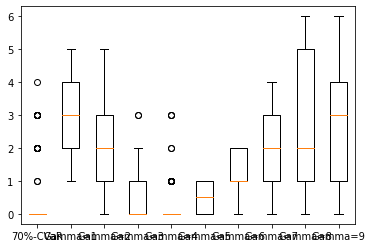

In [13]:
data=(tuple(pcvar),)
l=["70%-CVaR"]
for g in range(1,10):
  size=1000
  prob=[]
  for i in inst:
    ship_num=len(i[2])
    robust(ship_num,i[0],i[1],i[2],g,size)
    prob+=list(penalty_r)
    print(prob)
  data+=(tuple(prob),)
  l.append("Gamma="+str(g))
  # print("data=",data)
import matplotlib.pyplot as plt
plt.boxplot(data,labels=l)
plt.show()